# Submission 1, ML Assignment 1

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.externals import joblib
from my_measures import BinaryClassificationPerformance
%matplotlib inline

### Read raw test data

In [2]:
amazon = pd.read_csv('raw_data_test.csv')
print(amazon.shape)

(91000, 14)


In [3]:
print(amazon.head())
print(amazon['helpful'].mean())

   Unnamed: 0  Unnamed: 0.1      Id   ProductId          UserId  \
0        5019        567186  567187  B000LL0R92  A2CEPS4H5KB4G5   
1      183782        168172  168173  B005VOOKS8   AKT8TGIT6VVZ5   
2       86594         22530   22531  B003IMVB0K  A1AN1XNF7SH9F7   
3      197240        407078  407079  B000HDMUOE  A2WQ4FT0CMDSUI   
4      389002        382819  382820  B002T0IHPO  A32MNJDU9PMVWE   

                 ProfileName  HelpfulnessNumerator  HelpfulnessDenominator  \
0          Jilly from philly                     0                       0   
1                  John Kwok                     0                       1   
2  Keith Flury "Keith Flury"                     0                       0   
3               Profane Poet                     1                       2   
4             Robert D. Levy                     3                       6   

   Score        Time                                          Summary  \
0      2  1346889600  Only buy if you really like the o

### Feature extraction on natural language data

In [4]:
# # http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html
# from sklearn.feature_extraction.text import CountVectorizer
# vectorizer = CountVectorizer()
# corpus = amazon.Text.as_matrix()
# X_bag_of_words = vectorizer.fit_transform(corpus)
# print(X_bag_of_words.toarray())

In [5]:
# vectorize Bag of Words from review text; as sparse matrix
# from sklearn.feature_extraction.text import HashingVectorizer
# hv = HashingVectorizer(n_features=2 ** 17, non_negative=True)
hv = joblib.load('hv.pkl')
X_hv = hv.transform(amazon.Text)
print(X_hv.shape)

/Users/ryezzz/anaconda3/lib/python3.6/site-packages/sklearn/feature_extraction/hashing.py:94: DeprecationWarning: the option non_negative=True has been deprecated in 0.19 and will be removed in version 0.21.
  " in version 0.21.", DeprecationWarning)


(91000, 262144)


In [6]:
# http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfTransformer.html
# from sklearn.feature_extraction.text import TfidfTransformer
# transformer = TfidfTransformer()
transformer = joblib.load('transformer.pkl')
X_tfidf = transformer.transform(X_hv)

In [7]:
print(type(X_tfidf))

<class 'scipy.sparse.csr.csr_matrix'>


### Create additional quantitative features

In [8]:
import ryemodule
# features from Amazon.csv to add to feature set
# pd.get_dummies( df )
amazon['reviewLen'] = amazon['Text'].str.len()
#Test if certain users get better reviews   amazon['ProfileName']
amazon['goodReviewer'] = amazon['UserId'].apply(ryemodule.removeLetters).fillna(value=1)

# Didn't help
amazon['productID'] = amazon['ProductId'].apply(ryemodule.lettersToNumbers).fillna(value=1)

# Test if string begins with I
amazon['selfCentered'] = (amazon['Text'].str[0] == 'I') * 1
# Test if string contains !
amazon['exclaim'] = amazon['Text'].str.contains('!') * 1
amazon['exclaim2'] = amazon['Summary'].fillna(value='a').str.contains('!') * 1
amazon['selfCentered2'] = (amazon['Summary'].fillna(value='a').str[0] == 'I') * 1
# amazon['test'] = amazon['Text'].str.split().size
amazon['time'] = amazon['Time']

# amazon['Unnamed'] = amazon['Unnamed'].apply(lettersToNumbers).fillna(value=1)

# X_quant_features = amazon[['selfCentered', "reviewLen", 'exclaim', 'time']]
X_quant_features = amazon[['selfCentered',"Score", "reviewLen", 'exclaim', 'time', 'productID', 'exclaim2', 'selfCentered2', 'goodReviewer']]
# X_quant_features = amazon[['selfCentered',"Score", "reviewLen", 'exclaim', 'time', "goodReviewer", 'exclaim2', 'productID']]


# X_quant_features = amazon[['goodReviewer']]

print(X_quant_features.head(20))
# print(type(X_quant_features))

    selfCentered  Score  reviewLen  exclaim        time         productID  \
0              1      2        496        0  1346889600     2000121201892   
1              0      5        471        0  1333238400   200522151511198   
2              0      4        164        0  1342742400     2003913222011   
3              1      1        677        0  1320364800     2000841321155   
4              1      1        242        0  1291420800     2002200981615   
5              1      4        442        0  1315180800      200362651715   
6              0      5        247        0  1241049600  2000141310232615   
7              0      5        238        1  1134345600      200003142158   
8              1      5        373        1  1296086400     2004341051715   
9              1      4        315        0  1236297600     2000522151954   
10             0      5       1065        1  1310601600   200022824242319   
11             1      4        194        0  1325635200    20041232018613   

### Combine all quantitative features into a single sparse matrix

In [9]:
from scipy.sparse import csr_matrix, hstack
X_quant_features_csr = csr_matrix(X_quant_features)
X_combined = hstack([X_tfidf, X_quant_features_csr])
X_matrix = csr_matrix(X_combined) # convert to sparse matrix
print(X_matrix.shape)

(91000, 262153)


### Create `X`, scaled matrix of features

In [10]:
# feature scaling
# from sklearn.preprocessing import StandardScaler
# sc = StandardScaler(with_mean=False)
sc = joblib.load('sc.pkl')
X = sc.transform(X_matrix)
print(X.shape)

(91000, 262153)


### create `y`, vector of Labels

In [11]:
y = amazon['helpful'].values
print(type(y))

<class 'numpy.ndarray'>


### predict `y` with the fit on the training set

In [17]:
# MODEL: Naive Bayes
# from sklearn.naive_bayes import MultinomialNB
# nbs = MultinomialNB()
# nbs.fit(X, y)
# joblib.dump(nbs, 'nbs.pkl') # pickle
nbs = joblib.load('nbs.pkl')

nbs_performance = BinaryClassificationPerformance(nbs.predict(X), y, 'TOP SECRET')
nbs_performance.compute_measures()
print(nbs_performance.performance_measures)

{'Pos': 6638, 'Neg': 84362, 'TP': 2457, 'TN': 73359, 'FP': 11003, 'FN': 4181, 'Accuracy': 0.83314285714285718, 'Precision': 0.18254086181277859, 'Recall': 0.37014160891834891, 'desc': 'TOP SECRET'}


### ROC plot to compare performance of various models and fits

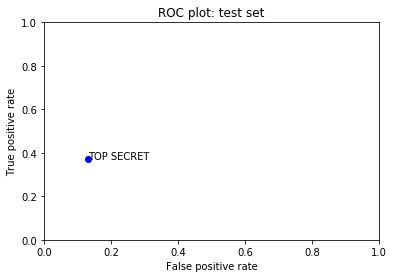

In [18]:
fits = [nbs_performance]

for fit in fits:
    plt.plot(fit.performance_measures['FP'] / fit.performance_measures['Neg'], 
             fit.performance_measures['TP'] / fit.performance_measures['Pos'], 'bo')
    plt.text(fit.performance_measures['FP'] / fit.performance_measures['Neg'], 
             fit.performance_measures['TP'] / fit.performance_measures['Pos'], fit.desc)
plt.axis([0, 1, 0, 1])
plt.title('ROC plot: test set')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.show()